# Preprocessing ABC notation files
- vectorize by custom dictionary
- total 5267 rows

In [1]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import os
import re
from itertools import product
from typing import List, Dict

from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import load_model

## Load Data

In [2]:
df = pd.read_csv('data/train.csv')
df['body'] = df['body'].apply(lambda x: eval(x))
print(df.shape)
df.head()

(5287, 6)


,T,M,L,K,body,body_str
0,The Enchanted Valley,2/4,1/16,Gm,[G3-A (Bcd=e) | f4 (g2dB) | ({d}c3-B) G2-E2 | ...,G3-A (Bcd=e) | f4 (g2dB) | ({d}c3-B) G2-E2 | F...
1,Fare You Well,2/4,1/16,D,[f-g | a3-b g3-a | f4 e3-d | d3-c A3-B | c4 d3...,f-g | a3-b g3-a | f4 e3-d | d3-c A3-B | c4 d3-...
2,The Little Heathy Hill,C,1/8,Gm,[B/2-c/2 | d2 d>-c B2 A-B | (GBAG) F2 D-F | (G...,B/2-c/2 | d2 d>-c B2 A-B | (GBAG) F2 D-F | (G>...
3,The Little Girl of my Heart,4/4,1/8,D,[F-G | A-dd>-c d2 cd | e-fgg (f2 d>e) | f-d (c...,F-G | A-dd>-c d2 cd | e-fgg (f2 d>e) | f-d (c/...
4,The Fun at Donnybrook,6/8,1/8,Gm,[B/2-A/2 | G>FD C>D^F | G3z2B/2-c/2 | B>cd cAG...,B/2-A/2 | G>FD C>D^F | G3z2B/2-c/2 | B>cd cAG ...


## Data Preprocessing

### Annotation 제거
- 단어 집합의 간소화를 위해 직접적으로 음에 영향을 끼치지 않는 annotation을 제거

In [3]:
df['body'] = df['body'].apply(lambda body: [re.sub('!([^!]*)!','',line) for line in body])
df['body'] = df['body'].apply(lambda body: [re.sub('"([^"]*)"','',line) for line in body])

### Parts 제거
- P:A, V:1 등으로 표현되는 파트는 모델로 구현하기 어렵기 때문에 이를 포함하는 곡을 제거

In [4]:
violated_index = list()

for i, body in enumerate(df['body']):
    parts = set()
    [parts.update(set(match)) for match in [re.findall('(P:.*)',line) for line in body]]
    [parts.update(set(match)) for match in [re.findall('(V:.*)',line) for line in body]]
    if len(parts) > 0:
        violated_index.append(i)

print('Dropped:', len(violated_index))
df.drop(index=violated_index, inplace=True)

df = df.reset_index().set_index('index')
df['body'] = df['body'].apply(lambda body: [str(line).strip() for line in body if len(line) > 0])
df['body_str'] = df['body'].apply(lambda body: '[SEP]'.join(body))

Dropped: 530


### Make Custom Vocabulary
- ABC notation 규칙에 부합하는 단어 목록을 지정

In [5]:
custom_vocab = [
    '[PAD]', '[SEP]', 'M:', 'L:', 'K:', 'Q:', 'treble', 'bass3', 'bass', 'tenor', 'alto1', 'alto2', 'alto',
    '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', "'", ',', '^', '=', '-', '_', '/',
    '|]', '||', '[|', '|:', ':|', '::', '|', ':', '(', ')', '{', '}', '[', ']',
    '.', '~', '>', '<', '`', 'z', 'Z', 'H', 'L', 'M', 'O', 'P', 'S', 'T', 'u', 'v',]
custom_vocab += list(map(lambda x: ''.join(x), product(['C','D','E','F','G','A','B'],['#m','bm','#','m','b',''])))
custom_vocab += ['c', 'd', 'e', 'f', 'g', 'a', 'b']
vocab_size = len(custom_vocab)

word2vec = {word:i for i,word in enumerate(custom_vocab)}
idx2word = {i:word for word,i in word2vec.items()}

print('Custom vocabulary:', word2vec)

Custom vocabulary: {'[PAD]': 0, '[SEP]': 1, 'M:': 2, 'L:': 3, 'K:': 4, 'Q:': 5, 'treble': 6, 'bass3': 7, 'bass': 8, 'tenor': 9, 'alto1': 10, 'alto2': 11, 'alto': 12, '0': 13, '1': 14, '2': 15, '3': 16, '4': 17, '5': 18, '6': 19, '7': 20, '8': 21, '9': 22, "'": 23, ',': 24, '^': 25, '=': 26, '-': 27, '_': 28, '/': 29, '|]': 30, '||': 31, '[|': 32, '|:': 33, ':|': 34, '::': 35, '|': 36, ':': 37, '(': 38, ')': 39, '{': 40, '}': 41, '[': 42, ']': 43, '.': 44, '~': 45, '>': 46, '<': 47, '`': 48, 'z': 49, 'Z': 50, 'H': 51, 'L': 52, 'M': 53, 'O': 54, 'P': 55, 'S': 56, 'T': 57, 'u': 58, 'v': 59, 'C#m': 60, 'Cbm': 61, 'C#': 62, 'Cm': 63, 'Cb': 64, 'C': 65, 'D#m': 66, 'Dbm': 67, 'D#': 68, 'Dm': 69, 'Db': 70, 'D': 71, 'E#m': 72, 'Ebm': 73, 'E#': 74, 'Em': 75, 'Eb': 76, 'E': 77, 'F#m': 78, 'Fbm': 79, 'F#': 80, 'Fm': 81, 'Fb': 82, 'F': 83, 'G#m': 84, 'Gbm': 85, 'G#': 86, 'Gm': 87, 'Gb': 88, 'G': 89, 'A#m': 90, 'Abm': 91, 'A#': 92, 'Am': 93, 'Ab': 94, 'A': 95, 'B#m': 96, 'Bbm': 97, 'B#': 98, 'Bm': 9

### Vectorization
- ABC notation 규칙에 부합하는 단어들만을 추출해 벡터로 변환

In [6]:
pattern = re.compile('|'.join(f'({re.escape(word)})' for word in custom_vocab))

df['body_str'] = df['body_str'].apply(lambda x: re.sub(pattern, lambda match: f' {match.group(0)} ', x).split())
vector = [[word2vec[char] for char in line if char in custom_vocab] for line in df['body_str']]
print('Vector size:', len(vector))

Vector size: 4757


### Padding

Maximum length: 1517
Minimum length: 8


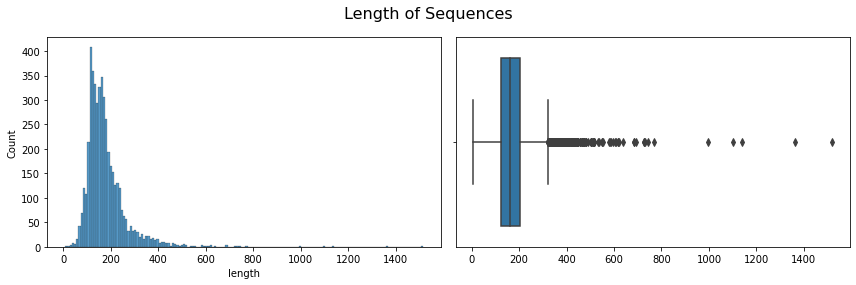

In [7]:
seq_len = {'length':[len(seq) for seq in vector]}

print('Maximum length:', max(seq_len['length']))
print('Minimum length:', min(seq_len['length']))

fig, ax = plt.subplots(1, 2, figsize=(12,4))
sns.histplot(ax=ax[0], data=seq_len, x='length')
sns.boxplot(ax=ax[1], data=seq_len, x='length')
plt.suptitle('Length of Sequences', fontsize=16)
plt.tight_layout()
plt.show()

학습 데이터를 동일한 길이로 맞추기 위해 전체 길이 분포를 시각화했을 때,   
최대 길이를 기준으로 패딩을 적용 시 공간의 낭비가 심할 것으로 예상

In [9]:
Q1 = np.percentile(seq_len['length'], 25)
Q3 = np.percentile(seq_len['length'], 75)
IQR = Q3 - Q1
outlier = 1.5 * IQR
pad_size = int(round(Q3 + outlier, -1))
print('Padding size:', pad_size)

Padding size: 320


IQR을 활용한 이상치 탐색 기법을 활용해 적절한 패딩 길이 지정

In [10]:
padded = pad_sequences(vector, padding='post', truncating='post', maxlen=pad_size+1)
train_X = padded[:,:-1]
train_y = padded[:,1:]

Char RNN을 학습시키기 위해 다음 단어에 해당하는 값을 라벨로 지정

In [11]:
print('X sample:', train_X[0][:10], '...')
print('y sample:', train_y[0][:10], '...')
print('-'*50)
print('X sample decoded:', ''.join([idx2word[i] for i in train_X[0] if i != 0]))
print('y sample decoded:', ''.join([idx2word[i] for i in train_y[0] if i != 0]))

X sample: [ 89  16  27  95  38 101 102 103  26 104] ...
y sample: [ 16  27  95  38 101 102 103  26 104  39] ...
--------------------------------------------------
X sample decoded: G3-A(Bcd=e)|f4(g2dB)|({d}c3-B)G2-E2|F4(D2=E^F)|[SEP]G3-A(Bcd=e)|f4d2-f2|(g2a2b2).g2|{b}(a2g2f2).d2|[SEP](d2{ed}c2)B2B2|(A2G2{AG}F2).D2|(GABc)(d2{ed}c>A)|G2G2G2z||[SEP]G|B2c2(dcAB)|G2G2G3G|B2d2(gfdc)|d2g2(g3ga)|[SEP](bagf)(gd)d>c|(B2AG)F-D.D2|(GABc)d2d2|(bgfd)cA.F2|[SEP]G2A2(B2{cB}AG)|A3-GF2-D2|(GABc)(d2{ed}c>A)|G2G2G2z2||
y sample decoded: 3-A(Bcd=e)|f4(g2dB)|({d}c3-B)G2-E2|F4(D2=E^F)|[SEP]G3-A(Bcd=e)|f4d2-f2|(g2a2b2).g2|{b}(a2g2f2).d2|[SEP](d2{ed}c2)B2B2|(A2G2{AG}F2).D2|(GABc)(d2{ed}c>A)|G2G2G2z||[SEP]G|B2c2(dcAB)|G2G2G3G|B2d2(gfdc)|d2g2(g3ga)|[SEP](bagf)(gd)d>c|(B2AG)F-D.D2|(GABc)d2d2|(bgfd)cA.F2|[SEP]G2A2(B2{cB}AG)|A3-GF2-D2|(GABc)(d2{ed}c>A)|G2G2G2z2||


### One-Hot Encoding

In [12]:
train_X = to_categorical(train_X, num_classes=vocab_size)
train_y = to_categorical(train_y, num_classes=vocab_size)

print('train_X shape:', train_X.shape)
print('train_y shape:', train_y.shape)

train_X shape: (4757, 320, 109)
train_y shape: (4757, 320, 109)


## Modeling

### Set Checkpoint Path

In [39]:
from datetime import datetime
now = datetime.now().strftime('%y%m%d_%H%M%S')

model_dir = './model'
save_dir = os.path.join(model_dir, now)

if not(os.path.isdir(model_dir)):
    os.mkdir(model_dir)
os.mkdir(save_dir)

model_path = save_dir + '/{epoch:02d}-{accuracy:.4f}.hdf5'

### Many-to-One Char RNN

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, TimeDistributed
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping

hidden_units = 512

model = Sequential()
model.add(LSTM(hidden_units, input_shape=(None, train_X.shape[2]), return_sequences=True))
model.add(LSTM(hidden_units, return_sequences=True))
model.add(TimeDistributed(Dense(vocab_size, activation='softmax')))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['loss'])
early_stopping = EarlyStopping(monitor='loss', patience=3)
cb_checkpoint = ModelCheckpoint(filepath=model_path, monitor='accuracy',
                                verbose=1, save_best_only=True)
history = model.fit(train_X, train_y, epochs=100, callbacks=[early_stopping, cb_checkpoint])

In [42]:
model = load_model('model/220708_154215/28-0.9972.hdf5')

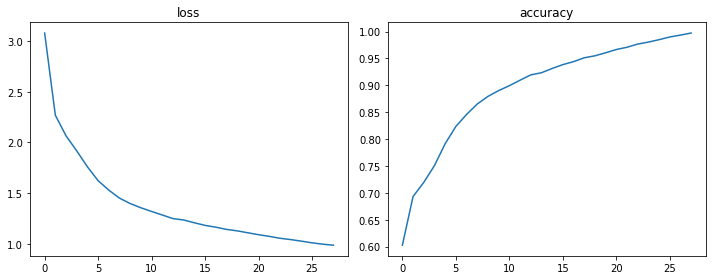

In [15]:
fig, ax = plt.subplots(1, 2, figsize=(10,4))
ax[0].plot(history.history['loss'])
ax[0].set_title('loss')
ax[1].plot(history.history['accuracy'])
ax[1].set_title('accuracy')
plt.tight_layout()
plt.show()

In [13]:
def sequence_encoding(seq: str):
    seq = re.sub(pattern, lambda match: f' {match.group(0)} ', seq).split()
    vector = [[word2vec[char] for char in seq if char in custom_vocab]]
    padded = pad_sequences(vector, padding='post', truncating='post', maxlen=pad_size)
    return to_categorical(padded, num_classes=vocab_size)

In [36]:
def sentence_generation(model, word2vec, seq_length, seed_text, n):

    # 초기 시퀀스
    init_text = seed_text
    sentence = ''

    # 다음 문자 예측은 총 n번만 반복.
    for _ in range(n):
        sequence = re.sub(pattern, lambda match: f' {match.group(0)} ', seed_text).split()
        encoded = [word2vec[char] for char in sequence if char in custom_vocab]
        padded = pad_sequences([encoded], padding='post', maxlen=seq_length)
        padded = to_categorical(padded, num_classes=vocab_size)

        # 입력한 X(현재 시퀀스)에 대해서 y를 예측하고 y(예측한 문자)를 result에 저장.
        result = model.predict(padded, verbose=0)
        result = np.argmax(result, axis=1)

        # 현재 시퀀스 + 예측 문자를 현재 시퀀스로 변경
        seed_text = seed_text + idx2word[result[0]]

        # 예측 문자를 문장에 저장
        sentence = sentence + idx2word[result[0]]

    # n번의 다음 문자 예측이 끝나면 최종 완성된 문장을 리턴.
    sentence = init_text + sentence
    return sentence

In [37]:
print(sentence_generation(model, word2vec, pad_size, 'G3-A', 80))

G3-AFmFmFmFmFm2Bm2A2DmDmDmDmDmDmDmDmDmDm[PAD][PAD]LLLLLLLD#D#D#D#3B#mB#mB#m)),,,,DbmDbmalto1alto155alto1alto1GbGb8888888OOOO.O:LLLLLEmEmBBBD#D#D#
